# Model Loading and Testing
by Prince Joseph Erneszer Javier

**Notes on Virtual Machine and Environment**
<br>Virtual Machine: AWS c5.9xlarge
<br>Operating System: Deep Learning AMI (Ubuntu) Version 23.0
<br>Environment: tensorflow_p36
<br>Storage Size: 85 GB

## Executive Summary

In this notebook, we evaluate the performance of our trained machine learning classifier on test data for Grab AI for SEA challenge under the Safety category. We were provided Telematics data and from these data we would develop models that can predict if a driver is driving safely or not. The raw features dataset contains 16 million samples and 11 columns including the `bookingID`. There are 20,000 unique `bookingID`'s each with either 0 or 1 corresponding to safe or unsafe driving. The data were preprocessed in `grab-ai-preprocessing-eda`. The models were trained in `grab-ai-training`. In this notebook, we developed a pipeline for processing and evaluating the performance of our trained models on test data that look like the raw data provided by Grab. Finally, `grab-ai-predicting` contains the pipeline for predicting on a new dataset.

To improve the generalizeability of the predictions, the average predictions of the top 2 models were used. The predictions for both min-max scaling and standard scaling were also derived, giving a total of 4 predictions per sample. The average prediction was used as the final prediction. The models for predicting are Gradient Boosting Machines and Nonlinear Support Vector Machines. These were all trained in `grab-ai-training`.

Using this ensemble of ML models, we got an accuracy of around 72%, which is higher than the proportional chance criterion (accuracy by random chance) of 62%. 76% of safe driving was predicted correctly, while 58% of unsafe driving was predicted correctly.

## Introduction

Grab AI for SEA challenge is a hackathon organized by Grab. Grab offers three challenges that can be solved using AI: Traffic Management, Computer Vision, and Safety. We tackle the Safety Challenge. The `Ride Safety` dataset was provided by Grab, which contains Telematics data (acceleration, gyroscope data, speed, etc.), `bookingID`, and labels (0 or 1 for safe or unsafe driving). The raw dataset was prepared in `grab-ai-preprocessing-eda`. The output of that notebook is used as input for machine learning classifier training. The models trained by `grab-ai-training` are evaluated on the 5% test set in this notebook.

## About the Data

The `Ride Safety` dataset contains two folders: `features` and `labels`. `features` contains 10 CSV files which contain a total of 16 million telematics data samples. The columns in the `features` dataset as described in `data_dictionary.xlsx` are:

|Column Name|Description|
|:--|:--|
|`bookingID`|trip id|
|`Accuracy`|accuracy inferred by GPS in meters|
|`Bearing`|GPS bearing|
|`acceleration_x`|accelerometer reading in x axis (m/s2)|
|`acceleration_y`|accelerometer reading in y axis (m/s2)|
|`acceleration_z`|accelerometer reading in z axis (m/s2)|
|`gyro_x`|gyroscope reading in x axis (rad/s)|
|`gyro_y`|gyroscope reading in y axis (rad/s)|
|`gyro_z`|gyroscope reading in z axis (rad/s)|
|`second`|time of the record by number of seconds|
|`Speed`|speed measured by GPS in m/s|

In `grab-ai-preprocessing-eda`, the samples were aggregated and features were engineered. `bookingID` and `second` were not included as features. The following measures were calculated for each feature: min, max, range, mean, standard deviation, skewness, kurtosis, dominant frequency (from fourier transform periodogram), and maximum power (from fourier transform periodogram). An additional feature was added which is the trip length.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from scipy.stats import kurtosis, skew
from scipy.signal import periodogram
from collections import Counter

from tensorflow import keras
from keras.models import load_model

seed = 42
np.random.seed(seed)

Using TensorFlow backend.


## Loading Data

We first loaded the test dataset.

In [2]:
# paths of features and labels
path_feats ="data/processed/df_test.csv"
path_labels = "data/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv"

df_feats = pd.read_csv(path_feats).drop_duplicates()
df_labels = pd.read_csv(path_labels).drop_duplicates()

## Data Preprocessing

### Feature Engineering

We then engineered features similar to what we did in `grab-ai-preprocessing-eda`.

In [3]:
def dominant_f(y):
    """Given time series y, get frequency of maximum power
    from periodogram"""
    f, p = periodogram(y, scaling='spectrum')
    ind = np.argsort(p)
    f_max = f[ind[-1]]
    return f_max


def max_power(y):
    """Given time series y, get maximum power"""
    f, p = periodogram(y, scaling='spectrum')
    return p.max()

In [4]:
# we engineer feature, aggregating feature values per bookingID
# getting min, max, range, mean, std, skewness, and kurtosis

df_engg_feats = df_feats.drop("second", axis=1)
df_engg_feats = df_engg_feats.groupby(by="bookingID", as_index=True).agg(
    [np.min, np.max, np.ptp, np.mean, np.std, skew, kurtosis, dominant_f, max_power])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [5]:
# flatten column names
cols = [df_engg_feats.columns[i][0] + "_" + df_engg_feats.columns[i][1]
        for i in range(len(df_engg_feats.columns))]

In [6]:
df_engg_feats.columns = cols
df_engg_feats.reset_index(inplace=True)

In [7]:
# add length of each trip
df_len = df_feats.groupby(by="bookingID", as_index=True).agg(len).iloc[:, 0:1]
df_len.columns = ['trip_len']
df_len.reset_index(inplace=True)

In [8]:
# merge along bookingID
df_engg_feats_2 = pd.merge(df_engg_feats, df_len, how="inner", on="bookingID")

In [9]:
# left join with labels (aggregating and feature engineering)
df_engg_feats_labels = pd.merge(
    df_engg_feats_2, df_labels, how="inner", on="bookingID")

In [10]:
df_engg_feats_labels.drop_duplicates(subset="bookingID", inplace=True)

In [11]:
# get feature set
X0 = df_engg_feats_2.drop(["bookingID"], axis=1)
cols = X0.columns

In [12]:
y = df_engg_feats_labels.label

There are 252 samples under class 1 and 748 classes under class 0.

In [13]:
# 0s and 1s
Counter(y)

Counter({0: 748, 1: 252})

The Proportional Chance Criterion or the probability of getting the right class by random chance is 62.3%.

In [14]:
# proportional chance criterion
state_counts = Counter(y)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
num = (df_state[0] / df_state[0].sum())**2
pcc = num.sum()
pcc

0.623008

## Model Predicting

We defined a function below that will return the predictions from multiple trained models.

In [15]:
# ensemble of top models


def predict(scaler="minmax"):
    """
    Given scaler name, scale dataset and predict using pretrained models
    Uses all features
    Return prediction as array of 0s and 1s from all models
    """

    # scaling
    path = f"scalers/{scaler}.sav"
    sc = pickle.load(open(path, 'rb'))

    y_preds = []

    # scale X
    X = pd.DataFrame(sc.transform(X0))
    X.columns = cols

    model_names = [f"models/{model}_{scaler}.sav" for model in ['gbm', 'svc']]

    for model_name in model_names:
        # load the model from disk (machine learning)
        filename = model_name
        model = pickle.load(open(filename, 'rb'))
        y_pred = model.predict(X)
        print(accuracy_score(y, y_pred), model_name)

        y_preds.append(y_pred)

    return y_preds

We predict on multiple models for both standard and min-max scaling. We printed the accuracy per model. Finally, we get the average value for each prediction and rounded them to 0 or 1. This will be used as the final prediction.

In [16]:
y_pred_minmax = predict("minmax")
y_pred_std = predict("std")

# concatenate results from std and minmax models
y_pred_all = y_pred_std + y_pred_minmax

# get average of all values
y_pred = np.round(np.array([np.array(i).flatten()
                            for i in y_pred_all]).mean(axis=0), 0)

0.703 models/gbm_minmax.sav
0.694 models/svc_minmax.sav
0.701 models/gbm_std.sav
0.675 models/svc_std.sav


Our accuracy using the ensemble of models is 71%.

In [17]:
# Evaluation
accuracy_score(y, y_pred)

0.718

We finally plot a confusion matrix comparing the true values and predicted values. We see that 75% of samples with 0 class were predicted correctly while 60% of samples with 1 class were predicted correctly. `grab-ai-predicting` contains the pipeline for predicting safe driving on new datasets.

Confusion matrix, without normalization
[[572 176]
 [106 146]]
Normalized confusion matrix
[[0.76 0.24]
 [0.42 0.58]]


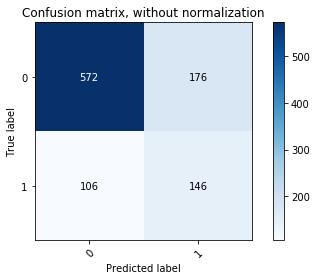

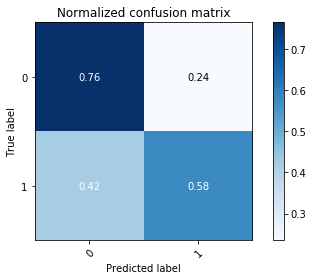

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0, 1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = [0, 1]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()